✅ 模型加载成功！
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 213, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 213, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 213, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
inception_block (InceptionModul (None, 128, 213, 96) 19584       batch_normalization[0][0]        
____________________________________________________________________________________

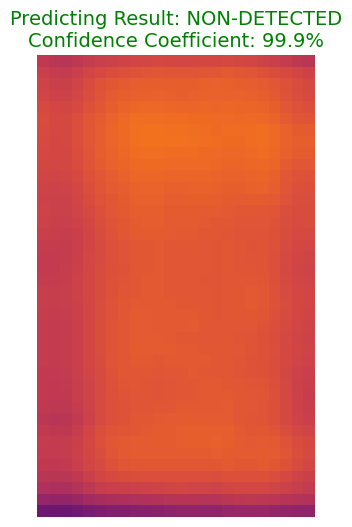

In [4]:
import tensorflow as tf
import numpy as np
import cv2
import os
from IPython.display import display, Markdown, Image
import matplotlib.pyplot as plt

# %% [code]
# 定义自定义层（必须与训练时相同）
class InceptionModule(tf.keras.layers.Layer):
    def __init__(self, filters, name="inception_block", **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters = filters
        self.branch1 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters[0], (1, 1), padding='same', activation='relu')
        ])
        self.branch2 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters[1], (1, 1), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters[2], (3, 3), padding='same', activation='relu')
        ])
        self.branch3 = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters[3], (1, 1), padding='same', activation='relu'),
            tf.keras.layers.Conv2D(filters[4], (5, 5), padding='same', activation='relu')
        ])
        self.branch4 = tf.keras.Sequential([
            tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same'),
            tf.keras.layers.Conv2D(filters[5], (1, 1), padding='same', activation='relu')
        ])
        
    def call(self, inputs):
        return tf.keras.layers.concatenate([
            self.branch1(inputs),
            self.branch2(inputs),
            self.branch3(inputs),
            self.branch4(inputs)
        ], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({'filters': self.filters})
        return config

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, name="multihead_attn", **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.Wq = tf.keras.layers.Dense(key_dim * num_heads)
        self.Wk = tf.keras.layers.Dense(key_dim * num_heads)
        self.Wv = tf.keras.layers.Dense(key_dim * num_heads)
        self.dense = tf.keras.layers.Dense(key_dim * num_heads)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        Q = tf.reshape(self.Wq(inputs), [batch_size, -1, self.num_heads, self.key_dim])
        K = tf.reshape(self.Wk(inputs), [batch_size, -1, self.num_heads, self.key_dim])
        V = tf.reshape(self.Wv(inputs), [batch_size, -1, self.num_heads, self.key_dim])
        attention = tf.einsum('bqhd,bkhd->bhqk', Q, K) / tf.sqrt(tf.cast(self.key_dim, tf.float32))
        attention = tf.nn.softmax(attention, axis=-1)
        output = tf.einsum('bhqk,bkhd->bqhd', attention, V)
        output = tf.reshape(output, [batch_size, -1, self.num_heads * self.key_dim])
        return self.dense(output), attention

    def get_config(self):
        return {'num_heads': self.num_heads, 'key_dim': self.key_dim}

# %% [code]
# 加载训练好的模型
model_path = "final_binary_model.h5"  # 修改为您的模型路径
custom_objects = {
    'InceptionModule': InceptionModule,
    'MultiHeadAttention': MultiHeadAttention
}

model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
print("✅ 模型加载成功！")
model.summary()

# %% [code]
# 定义预处理函数
def preprocess_image(image, target_size=(128, 213)):
    """
    预处理函数（与训练时完全相同）
    参数:
        image : numpy数组或文件路径
        target_size : 目标尺寸 (height, width)
    返回:
        预处理后的numpy数组
    """
    # 如果是文件路径，读取图片
    if isinstance(image, str):
        if not os.path.exists(image):
            raise FileNotFoundError(f"文件 {image} 不存在")
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 调整尺寸并归一化
    resized = cv2.resize(image, (target_size[1], target_size[0]), interpolation=cv2.INTER_CUBIC)
    normalized = resized.astype(np.float32) / 255.0
    return np.expand_dims(normalized, axis=0)  # 添加batch维度



# %% [markdown]
# ## 或者使用本地图片路径测试
# 修改下方路径后运行单元格

# %% [code]
# 本地图片测试示例
test_image_path = r"E:\CDUT\English\7 Term\Project\model\archive\panel_cell\non-detected\10000.png"  # 修改为您的测试图片路径

# 预处理和预测
try:
    processed = preprocess_image(test_image_path)
    prediction = model.predict(processed)
    
    # 显示图片和结果
    img = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8,6))
    plt.imshow(img)
    plt.axis('off')
    
    confidence = prediction[0][0]
    class_name = "detected" if confidence > 0.5 else "non-detected"
    confidence_percent = abs(confidence-0.5)*2  # 转换为0-100%置信度
    
    result_text = f"Predicting Result: {class_name.upper()}\nConfidence Coefficient: {confidence_percent:.1%}"
    plt.title(result_text, fontsize=14, color='red' if class_name == "detected" else 'green')
    plt.show()
    
except Exception as e:
    print(f"error: {str(e)}")